## Import Library

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive")

['Annabel Gracia Puryani SaDa.PNG',
 '22083010048_Annabel G_Kewarganegaraan G1.pdf',
 'Y',
 'A6347BB1-E4BF-4204-8D36-58D961F5237F.png',
 '43D5BCFB-4E65-42E4-AAF2-551FE6FCDD20.jpeg',
 '22083010048_Annabel Gracia_StatkomC_P04ipynb.ipynb',
 'Colab Notebooks',
 'Statreg',
 'Tugas Statistika Regresi P2 - 048 - 075 - 077 document.gdoc',
 'Statistika_Regresi_Tugas03_048,075,077.ipynb',
 'Statistika Regresi_Tugas04_Kelompok06.pptx',
 'SURATKOMITMENFF2023_ANNABEL GRACIA PURYANI.pdf',
 'Transkrip_Annabel.pdf',
 'Tugas_Multiple Linier Regression.pdf',
 'LS_22083010048_Annabel Gracia_Statistika Regresi B.xlsx',
 'Annabel Gracia_22083010048 (3).pdf',
 'Annabel Gracia_22083010048 (2).pdf',
 '0AABB7D9-CDD5-4DBC-B5B8-C60D30E11CF9.jpeg',
 'PHOTO-2023-09-04-22-54-37.jpg',
 'StatregB_Uji Heteroskedastisitas_Kelompok 6.xlsx',
 '24694A1A-3444-4277-8258-141B06410395.png',
 '851C4C3A-5820-4687-AD11-0EE37D8DBC61.png',
 'Surat Izin Annabel Gracia-048 (1).pdf',
 'Surat Izin Annabel Gracia-048.pdf',
 '2208301004

In [ ]:
os.listdir("/content/drive/MyDrive/PlantVillage")

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/PlantVillage"

## Summary Dataframe dari Struktur Direktori

In [ ]:
data_summary = []

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        data_summary.append({
            "class_name": class_name,
            "num_images": num_images
        })

df_summary = pd.DataFrame(data_summary)
df_summary = df_summary.sort_values("num_images", ascending=False).reset_index(drop=True)

df_summary

class_name  num_images
0         Tomato__Tomato_YellowLeaf__Curl_Virus        3209
1                         Tomato_Bacterial_spot        2127
2                            Tomato_Late_blight        1909
3                     Tomato_Septoria_leaf_spot        1771
4   Tomato_Spider_mites_Two_spotted_spider_mite        1676
5                                Tomato_healthy        1591
6                        Pepper__bell___healthy        1478
7                           Tomato__Target_Spot        1404
8                         Potato___Early_blight        1000
9                          Potato___Late_blight        1000
10                          Tomato_Early_blight        1000
11                Pepper__bell___Bacterial_spot         997
12                             Tomato_Leaf_Mold         952
13                  Tomato__Tomato_mosaic_virus         373
14                             Potato___healthy         152

## Distribusi Dataset

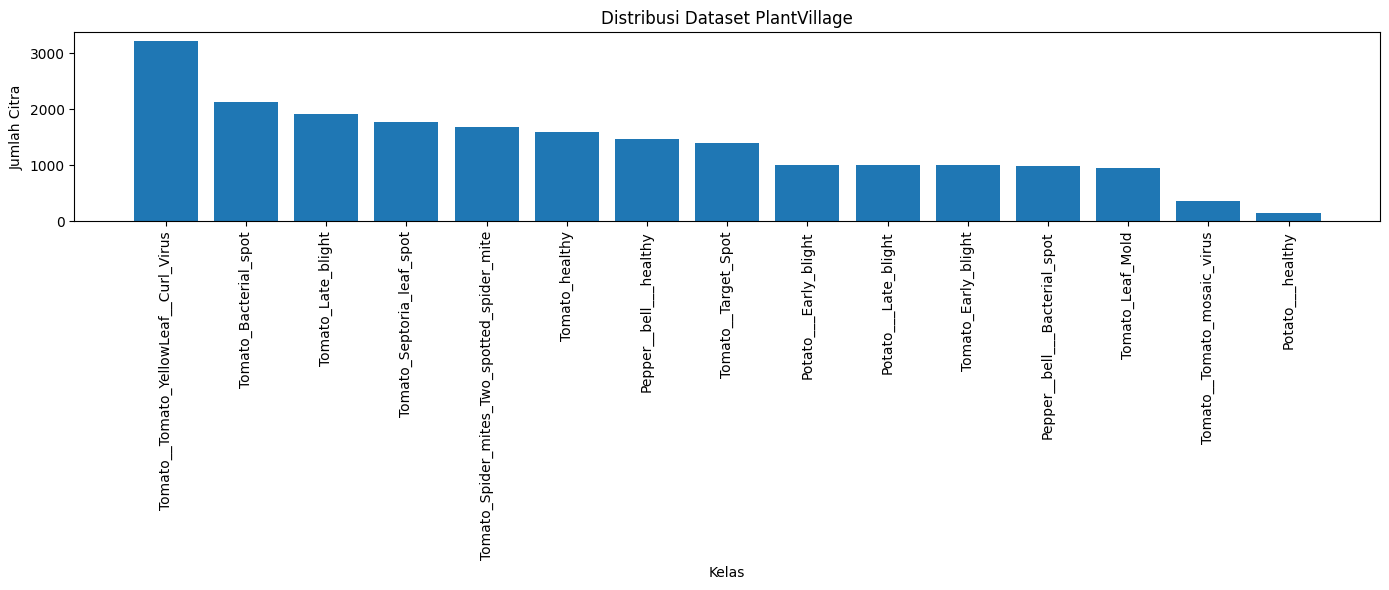

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df_summary["class_name"], df_summary["num_images"])
plt.xticks(rotation=90)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Citra")
plt.title("Distribusi Dataset PlantVillage")
plt.tight_layout()
plt.show()

## Menampilkan Sample Images Per Kelas

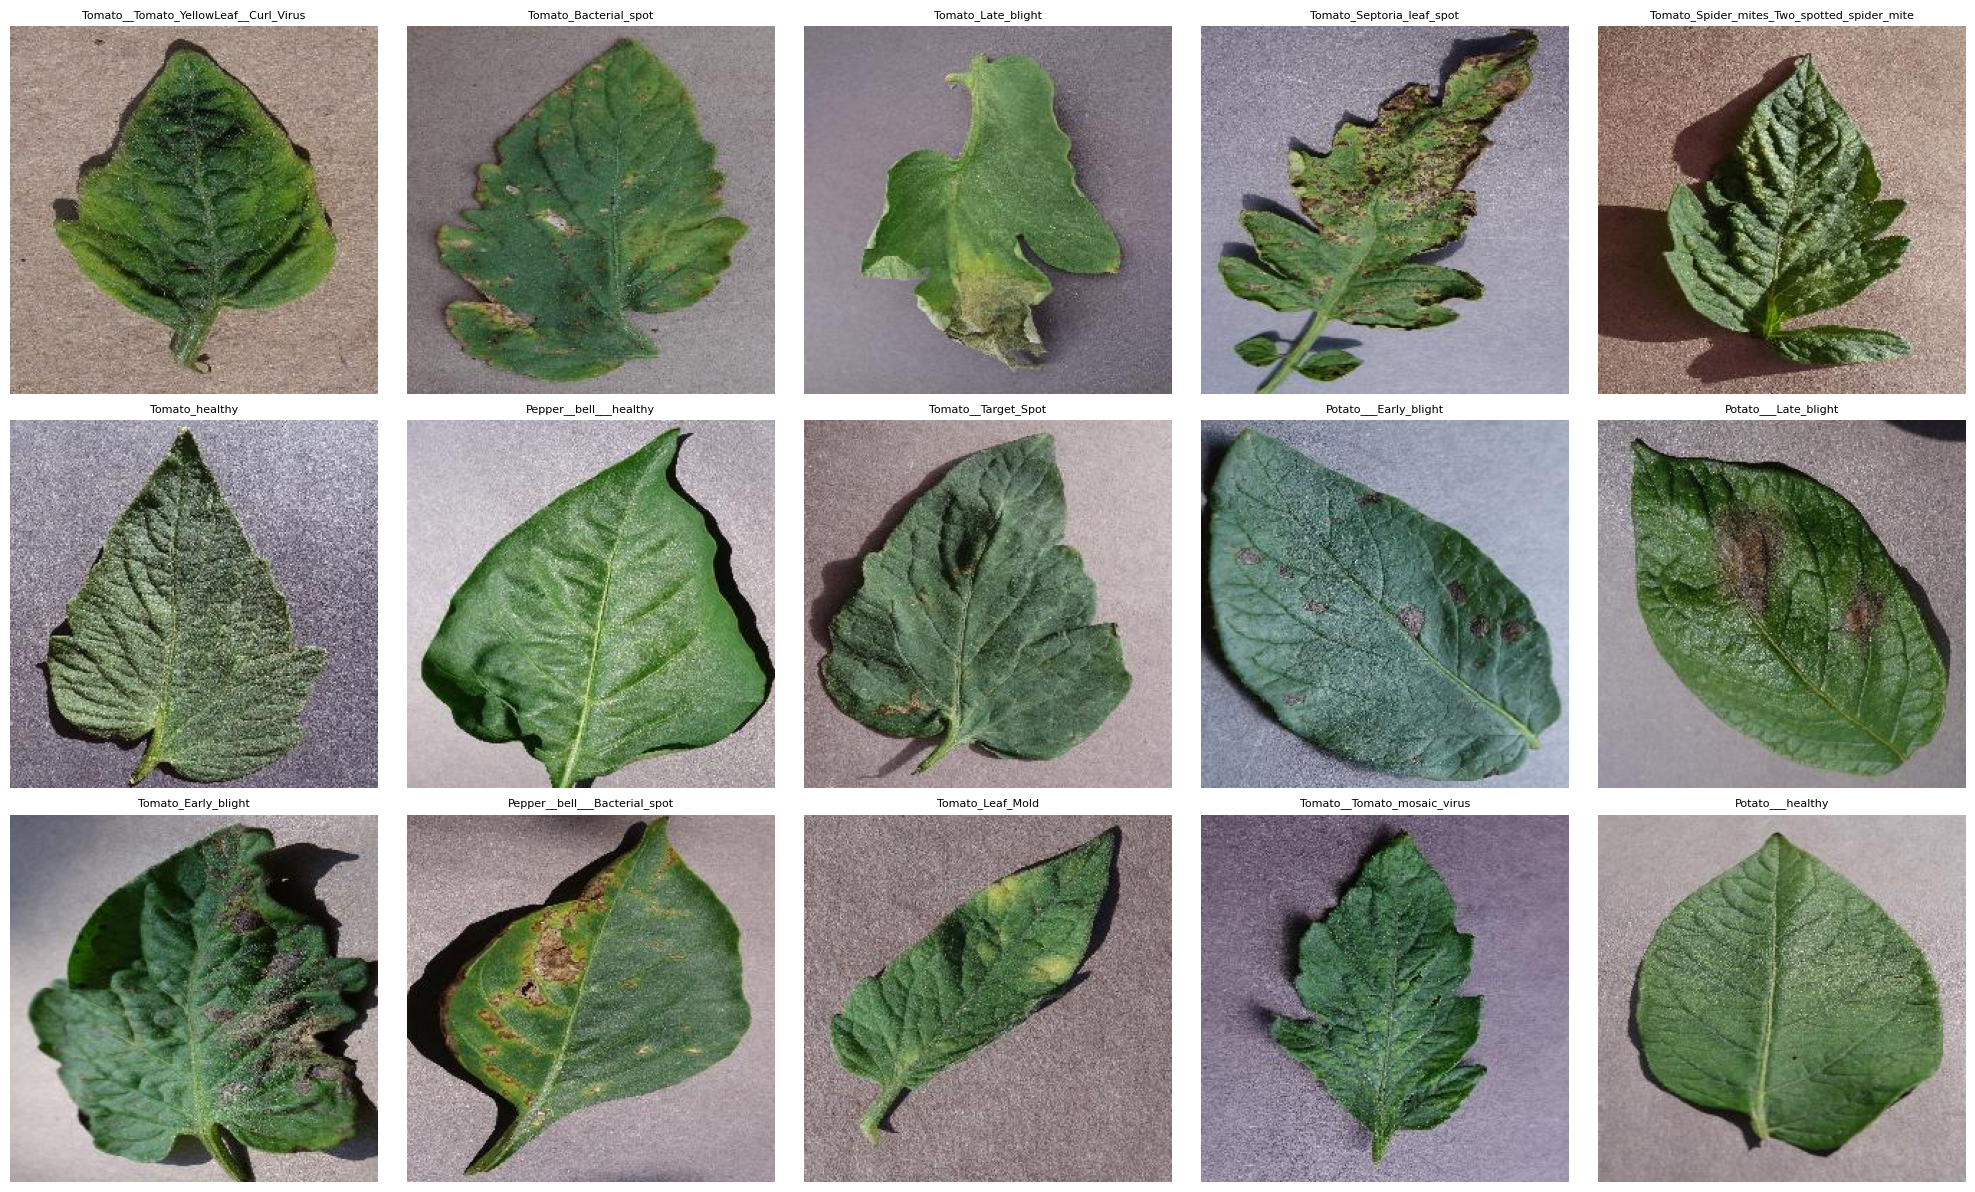

In [ ]:
import math

num_classes = len(df_summary)
cols = 5
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(cols * 4, rows * 4))

for i, cls in enumerate(df_summary["class_name"]):
    cls_path = os.path.join(DATASET_PATH, cls)

    img_name = os.listdir(cls_path)[0]   # ambil 1 gambar per kelas
    img_path = os.path.join(cls_path, img_name)

    img = plt.imread(img_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Image Data Generator

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/PlantVillage"

IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32
EPOCHS = 10

## Load Dataset ke Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

### Data Training

In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### Data Validasi

In [ ]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = train_generator.num_classes

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


## Model CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu",
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,248,527 (84.87 MB)

 Trainable params: 22,248,527 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2107s 4s/step - accuracy: 0.3172 - loss: 2.1265 - val_accuracy: 0.6948 - val_loss: 0.8734
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2111s 4s/step - accuracy: 0.6432 - loss: 1.0949 - val_accuracy: 0.5898 - val_loss: 1.4546
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2121s 4s/step - accuracy: 0.7075 - loss: 0.8760 - val_accuracy: 0.7407 - val_loss: 0.8427
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2063s 4s/step - accuracy: 0.7449 - loss: 0.7613 - val_accuracy: 0.7215 - val_loss: 0.9381
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2098s 4s/step - accuracy: 0.7788 - loss: 0.6488 - val_accuracy: 0.8513 - val_loss: 0.4194
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2100s 4s/step - accuracy: 0.7983 - loss: 0.5903 - val_accuracy: 0.8020 - val_loss: 0.6154
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2107s 4s/step - accuracy: 0.8279 - loss: 0.5141 - val_accuracy: 0.7853 - val_loss: 0.7426
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2080s 4s/step - accuracy: 0.8384 - loss: 0.4725 - 

## Evaluasi Model

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(binary_true, binary_pred)
print("Akurasi biner (Sehat vs Sakit):", acc)

Akurasi biner (Sehat vs Sakit): 0.9618885096700797


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(binary_true, binary_pred, labels=["SEHAT", "SAKIT"])
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 956,   12],
       [ 189, 4117]])

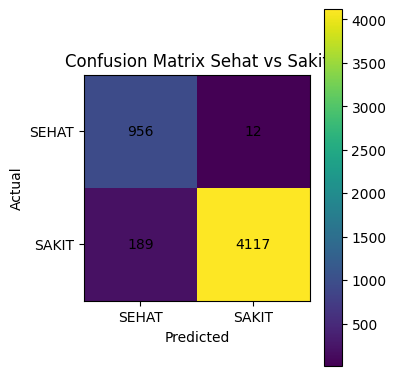

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.colorbar()

plt.xticks([0,1], ["SEHAT", "SAKIT"])
plt.yticks([0,1], ["SEHAT", "SAKIT"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Sehat vs Sakit")
plt.tight_layout()
plt.show()

## Fungsi Konversi Multiclass → Biner

In [ ]:
healthy_samples = []
sick_samples = []

val_generator.reset()

for images, labels in val_generator:
    preds = model.predict(images, verbose=0)

    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels, axis=1)

    for img, p, t in zip(images, pred_classes, true_classes):
        pred_label = to_binary(p)
        true_label = to_binary(t)

        if true_label == "SEHAT" and len(healthy_samples) < 3:
            healthy_samples.append((img, pred_label, true_label))

        if true_label == "SAKIT" and len(sick_samples) < 3:
            sick_samples.append((img, pred_label, true_label))

        if len(healthy_samples) == 3 and len(sick_samples) == 3:
            break

    if len(healthy_samples) == 3 and len(sick_samples) == 3:
        break


## Tampilkan Hasil  3 Daun Sehat & 3 Daun Sakit

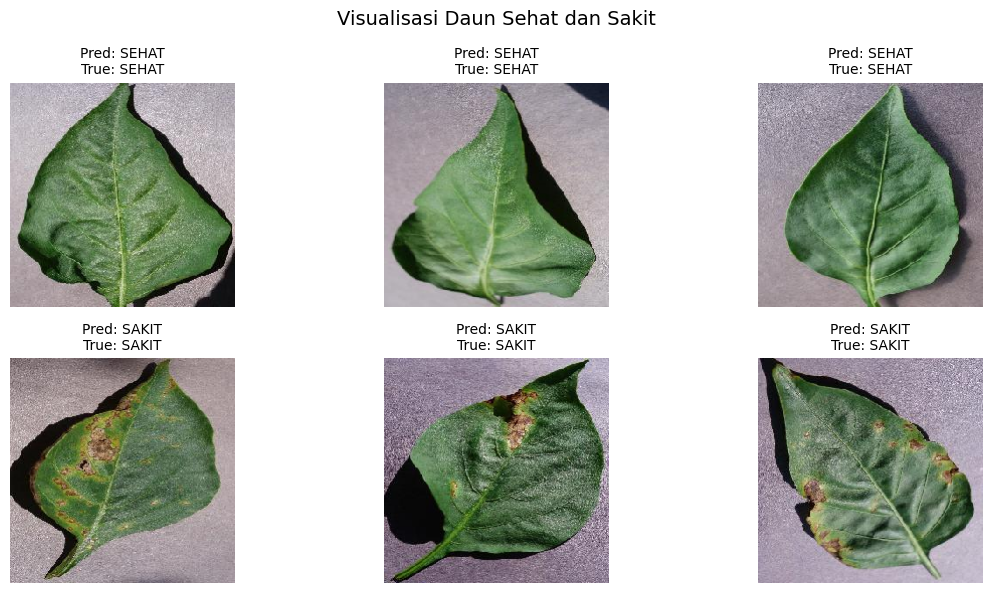

In [ ]:
plt.figure(figsize=(12, 6))

samples = healthy_samples + sick_samples

for i, (img, p, t) in enumerate(samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {p}\nTrue: {t}", fontsize=10)

plt.suptitle("Visualisasi Daun Sehat dan Sakit", fontsize=14)
plt.tight_layout()
plt.show()

## Perbandingan Daun Sehat dan Sakit

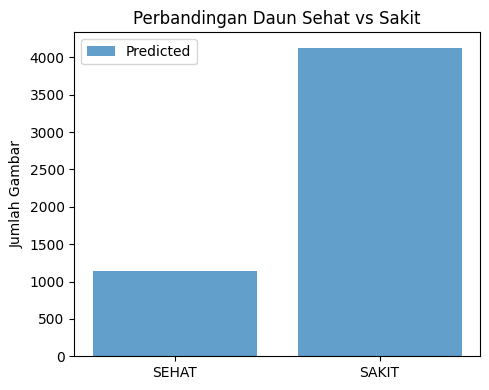

In [ ]:
import matplotlib.pyplot as plt

labels = ["SEHAT", "SAKIT"]

pred_healthy = binary_pred.count("SEHAT")
pred_sick    = binary_pred.count("SAKIT")

plt.figure(figsize=(5,4))
plt.bar(labels, [pred_healthy, pred_sick], alpha=0.7, label="Predicted")

plt.ylabel("Jumlah Gambar")
plt.title("Perbandingan Daun Sehat vs Sakit")
plt.legend()
plt.tight_layout()
plt.show()